### Define class

In [1]:
from neuron import h
import math
import numpy as np
import pandas as pd

h.load_file('stdrun.hoc')

class Stylized_Cell(object):
    def __init__(self,geometry=None,dL=30,vrest=-70.0):
        self._h = h
        self._dL = dL
        self._vrest = vrest
        self._nsec = 0
        self._nseg = 0
        self.all = []
        self.segments = []
        self.sec_id_in_seg = []
        self.seg_coords = {}
        self.injection = []
        self.set_geometry(geometry)
        self.setup_all()
        
    def setup_all(self):
        if self.geometry is not None:
            self.set_morphology()
            self.set_channels()
#             self.calc_seg_coords()
#             self.init_v()
    
    def set_geometry(self,geometry):
        if geometry is None:
            self.geometry = None
        else:
            if not isinstance(geometry,pd.DataFrame):
                raise TypeError("geometry must be a pandas dataframe")
            if geometry.iloc[0]['type']!=1:
                raise ValueError("first row of geometry must be soma")
            self.geometry = geometry.copy()
    
    def set_morphology(self):
        if self.geometry is None:
            print("Warning: geometry is not loaded.")
            return None
        self._nsec = 0
        self.all = []
        sec_index = [0]*len(self.geometry.index)
        for j,sec in self.geometry.iterrows():
            axial = sec['axial']
            L = sec['L']
            R = sec['R']
            ang = sec['ang']
            sec_index[j] = self._nsec
            section = self.add_section(name=sec['name'],diam=2*R)
            if j==0:
                R0 = R
                nseg = 1
                self.soma = section
                pt0 = [0.,-2*R0,0.]
                pt1 = [0.,0.,0.]
            else:
                nseg = math.ceil(L/self._dL)
                pid = sec_index[sec['pid']]
                psec = self.all[pid]
                pt0 = [psec.x3d(1),psec.y3d(1),psec.z3d(1)]
                pt1 = [0.,L*math.sin(ang),0.]
                if not axial:
                    pt1[0] = L*math.cos(ang)
                for i in range(3):
                    pt1[i] += pt0[i]
                section.connect(psec(1),0)
            self.set_location(section,pt0,pt1,nseg)
            if not axial:
                section = self.add_section(name=sec['name'],diam=2*R)
                section.connect(psec(1),0)
                pt1[0] = -pt1[0]
                self.set_location(section,pt0,pt1,nseg)
        self.set_location(self.soma,[0.,-R0,0.],[0.,R0,0.],1)
        self.store_segments()
    
    def add_section(self,name='null_sec',diam=500.0):
        sec = h.Section(name=name)
        sec.diam = diam
        self.all.append(sec)
        self._nsec += 1
        return sec
    
    def set_location(self,sec,pt0,pt1,nseg):
        sec.pt3dclear()
        sec.pt3dadd(*pt0,sec.diam)
        sec.pt3dadd(*pt1,sec.diam)
        sec.nseg = nseg
    
    def store_segments(self):
        self.segments = []
        self.sec_id_in_seg = []
        nseg = 0
        for sec in self.all:
            self.sec_id_in_seg.append(nseg)
            nseg += sec.nseg
            for seg in sec:
                self.segments.append(seg)
        self._nseg = nseg
    
    def calc_seg_coords(self):
        p0 = np.empty((self._nseg,3))
        p1 = np.empty((self._nseg,3))
        p05 = np.empty((self._nseg,3))
        r = np.empty(self._nseg)
        for isec,sec in enumerate(self.all):
            iseg = self.sec_id_in_seg[isec]
            nseg = sec.nseg
            pt0 = np.array([sec.x3d(0),sec.y3d(0),sec.z3d(0)])
            pt1 = np.array([sec.x3d(1),sec.y3d(1),sec.z3d(1)])
            pts = np.linspace(pt0,pt1,2*nseg+1)
            p0[iseg:iseg+nseg,:] = pts[:-2:2,:]
            p1[iseg:iseg+nseg,:] = pts[2::2,:]
            p05[iseg:iseg+nseg,:] = pts[1:-1:2,:]
            r[iseg:iseg+nseg] = sec.diam/2
        self.seg_coords = {}
        self.seg_coords['dl'] = p1-p0  # length direction vector
        self.seg_coords['pc'] = p05  # center coordinates
        self.seg_coords['r'] = r  # radius
    
    def get_sec_by_id(self,index=None):
        if not isinstance(index, (list,tuple,np.ndarray)):
            index = [index]
        return [self.all[i] for i in index]
    
    def get_seg_by_id(self,index=None):
        if not isinstance(index, (list,tuple,np.ndarray)):
            index = [index]
        return [self.segments[i] for i in index]
    
    def set_channels(self):
        pass
    
    def set_all_passive(self,gl=0.0003):
        for sec in self.all:
            sec.cm = 1.0
            sec.insert('pas')
            sec.g_pas = gl
            sec.e_pas = self._vrest
    
    def set_soma_hh(self,gl_dend=0.0003,**soma_param):
        for sec in self.all:
            sec.cm = 1.0
        self.soma.insert('hh')
        self.soma.el_hh = self._vrest
        for param,value in soma_param.items():
            setattr(self.soma,param+'_hh',value)
        for sec in self.all[1:]:
            sec.insert('pas')
            sec.g_pas = gl_dend
            sec.e_pas = self._vrest
    
    def add_injection(self,sec_index,**kwargs):
        self.injection.append(Current_injection(self,sec_index,**kwargs))
    
    def set_h(self,**h_param):
        for param,value in h_param.items():
            setattr(h,param,value)
    
    def init_v(self):
        for seg in self.segments:
            seg.v = self.vrest

class Current_injection(object):
    def __init__(self,cell,sec_index,loc=0.5,pulse=True,current=[0],Dt=None,record=False,**pulse_param):
        self.cell = cell
        self.sec_index = sec_index
        self.ccl = h.IClamp(self.get_section()(loc))
        self.inj_vec = self.rec_vec = None
        if pulse:
            self.setup_pulse(**pulse_param)
        else:
            self.setup_current(current,Dt)
        if record:
            self.setup_recorder()
    
    def setup_pulse(self,**pulse_param):
        for param,value in pulse_param.items():
            setattr(self.ccl,param,value)
    
    def setup_current(self,current,Dt):
        self.ccl.dur = 0
        self.ccl.dur = h.tstop if hasattr(h,'tstop') else 1e30
        if Dt is None:
            Dt = h.dt
        self.inj_vec = h.Vector()
        self.inj_vec.from_python(current)
        self.inj_vec.append(0)
        self.inj_vec.play(self.ccl._ref_amp,Dt)
    
    def setup_recorder(self):
        size = [round(h.tstop/h.dt)+1] if hasattr(h,'tstop') else []
        self.rec_vec = h.Vector(*size).record(self.ccl._ref_i)
    
    def get_section(self):
        return self.cell.all[self.sec_index]
    
    def get_segment(self):
        return self.ccl.get_segment()
    
    def get_segment_id(self):
        iseg = math.floor(self.get_segment().x*self.get_section().nseg)
        return self.cell.sec_id_in_seg[self.sec_index]+iseg

class Recorder(object):
    def __init__(self,obj_list,var_name='v'):
        if not isinstance(obj_list, (list,tuple,np.ndarray)):
            obj_list = [obj_list]
            self.single = True
        else:
            self.single = False
        self.obj_list = obj_list
        self.var_name = var_name
        self.vectors = []
        self.setup_recorder()
        
    def setup_recorder(self):
        size = [round(h.tstop/h.dt)+1] if hasattr(h,'tstop') else []
        attr_name = '_ref_'+self.var_name
        for obj in self.obj_list:
            self.vectors.append( h.Vector(*size).record( getattr(obj,attr_name) ) )
    
    def as_numpy(self):
        if self.single:
            x = self.vectors[0].as_numpy()
        else:
            x = np.array([v.as_numpy() for v in self.vectors])
        return x


In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R

class EcpMod(object):
    def __init__(self,cell,electrode_positions,move_cell=None,scale=1.0,min_distance=None):
        self.cell = cell
        self.elec_coords = np.array(electrode_positions)
        if self.elec_coords.ndim!=2 or self.elec_coords.shape[1]!=3:
            raise ValueError("electrode_positions must be an n-by-3 2-D array")
        self.nelec = self.elec_coords.shape[0]
        self.record_im()
        self.cell.calc_seg_coords()
        self.calc_transfer_resistance(move_cell,scale,min_distance)
    
    def record_im(self):
        self.cell._h.cvode.use_fast_imem(1)
        for sec in self.cell.all:
            sec.insert('extracellular')  # insert extracellular
        self.im_rec = Recorder(self.cell.segments,'i_membrane_')
        for inj in self.cell.injection:
            if inj.rec_vec is None:
                inj.setup_recorder()
    
    def calc_transfer_resistance(self,move_cell,scale,min_distance):
        """
        Precompute mapping from segment to electrode locations
        move_cell: tuple of (translate,rotate), rotate the cell followed by translating it
        scale: scaling factor of ECP magnitude
        min_distance: minimum distance allowed between segment and electrode, if specified
        """
        sigma = 0.3  # mS/mm
        seg_coords = self.cell.seg_coords
        if move_cell is None:
            dl = seg_coords['dl']
            pc = seg_coords['pc']
        else:
            dl = newposition([0.,0.,0.],move_cell[1],seg_coords['dl'])
            pc = newposition(move_cell[0],move_cell[1],seg_coords['pc'])
        if min_distance is None:
            r = seg_coords['r']
        else:
            r = np.fmax(seg_coords['r'],min_distance)
        tr = np.empty((self.nelec,self.cell._nseg))
        for j in range(self.nelec):  # calculate mapping for each site on the electrode
            rel_pc = self.elec_coords[j,:]-pc  # distance between electrode and segment centers
            # compute dot product row-wise, the resulting array has as many rows as original
            r2 = np.einsum('ij,ij->i',rel_pc,rel_pc)
            rlldl = np.einsum('ij,ij->i',rel_pc,dl)
            dlmag = np.linalg.norm(dl,axis=1)  # length of each segment
            rll = abs(rlldl / dlmag)  # component of r parallel to the segment axis it must be always positive
            rT2 = r2 - rll ** 2  # square of perpendicular component
            up = rll + dlmag / 2
            low = rll - dlmag / 2
            np.fmax(rT2, r ** 2, out=rT2, where= low - r < 0)
            num = up + np.sqrt(up ** 2 + rT2)
            den = low + np.sqrt(low ** 2 + rT2)
            tr[j,:] = np.log(num / den) / dlmag  # units of (um) use with im_ (total seg current)
        self.tr = scale/(4*np.pi*sigma)*tr
    
    def calc_ecp(self):
        im = self.im_rec.as_numpy()
        for inj in self.cell.injection:
            im[inj.get_segment_id(),:] -= inj.rec_vec.as_numpy()
        ecp = np.dot(self.tr,im)
        return ecp

def newposition(translate,rotate,old_position=[0.,0.,0.],move_frame=False):
    """
    Rotate and translate an object with old_position and calculate its new coordinates.
    Rotate(alpha,h,phi): first rotate alpha about y-axis (spin), then rotate -arccos(h) about z-axis (elevation), then rotate phi about y axis (azimuth).
    Finally translate the object by translate(x,y,z).
    If move_frame is True, use the object as reference frame and move the old reference frame, calculate new coordinates of the old_position.
    """
    translate = np.asarray(translate)
    old_position = np.asarray(old_position)
    Rot = R.from_euler('yzy',[rotate[0],-np.arccos(rotate[1]),rotate[2]])
    if move_frame:
        new_position = Rot.inv().apply(old_position-translate)
    else:
        new_position = Rot.apply(old_position)+translate
    return new_position

### Set up model

In [1]:
from stylized_module.stylized_cell import Stylized_Cell
from stylized_module.ecp import EcpMod, newposition
from stylized_module.recorder import Recorder

In [3]:
import pandas as pd
import numpy as np

geo_prop = pd.read_csv('geom_parameters.csv',index_col='id')
# geo_prop

In [4]:
cell = Stylized_Cell(geometry=geo_prop)

Constant current injection

In [5]:
cell.set_soma_hh(gl_dend=0.0001,gnabar=0.3,gkbar=0.02,gl=0.0001)
# cell.set_h(tstop=100.)
# cell.add_injection(sec_index=0,delay=20.,amp=0.2,dur=50.)
cell.set_h(tstop=20.)
cell.add_injection(sec_index=0,delay=5.,amp=2.0,dur=0.1,record=True)
i_rec = Recorder(cell.soma(.5),'il_hh')

Customized current injection

In [6]:
cell.set_all_passive()
cell.set_h(tstop=20.)
dt = cell._h.dt
t = np.arange(0,10,dt)
i_inj = np.concatenate([np.zeros(round(5/dt)),1.0*np.sin(2*np.pi*0.18*t)])
cell.add_injection(sec_index=0,pulse=False,current=i_inj,record=True)
i_rec = Recorder(cell.soma(.5),'i_pas')

Record variables

In [7]:
t_rec = Recorder(cell._h,'t')
v_rec = Recorder(cell.get_seg_by_id(cell.sec_id_in_seg))

Record LFP

In [8]:
elec_file = 'linear_electrode.csv'
pos = pd.read_csv(elec_file,sep=' ')[[x+'_pos' for x in list('xyz')]].values

prior_min = np.array([0,-2000,-1,0])
prior_max = np.array([200,2000,1,np.pi])
params = np.random.uniform(prior_min,prior_max)
print(params)
translate = np.insert(params[:2],2,0.) # translate cell along x,y only
rotate = np.insert(params[2:],0,0.)

[ 1.90037620e+02  6.38349406e+02 -5.40192618e-01  4.82192483e-01]


move cell

In [9]:
LFP = EcpMod(cell,pos,move_cell=(translate,rotate))

equivalently move electrode

In [12]:
LFP = EcpMod(cell,newposition(translate,rotate,pos,move_frame=True),min_distance=10.0)

### Simulate and results

In [13]:
cell._h.run()

t = t_rec.as_numpy()

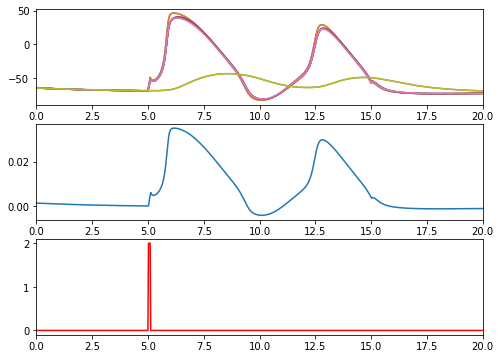

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))
plt.subplot(311)
plt.plot(t,v_rec.as_numpy().T)
plt.xlim(t[0],t[-1])
plt.subplot(312)
plt.plot(t,i_rec.as_numpy())
plt.xlim(t[0],t[-1])
plt.subplot(313)
plt.plot(t,cell.injection[0].rec_vec.as_numpy(),'r')
plt.xlim(t[0],t[-1])
plt.show()

<IPython.core.display.Javascript object>


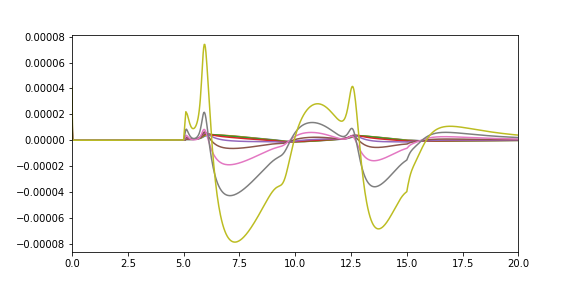

In [17]:
%matplotlib notebook

lfp = LFP.calc_ecp()
plt.figure(figsize=(8,4))
for i in range(lfp.shape[0]):
    plt.plot(t,lfp[i,:], label='ch'+str(i))
plt.xlim(t[0],t[-1])
plt.show()

### Delete model

In [7]:
del cell,i_rec,v_rec

In [18]:
from neuron import h

for sec in h.allsec():
    print(sec.name())
    print(sec.nseg)

soma
1
axon
2
basal
7
basal
7
apical
6
apical
6
trunk
17
tuft
5
tuft
5


### Check model properties

In [19]:
from neuron import h

for s in cell.all:
    print(s.diam,s.L,s.nseg)
print(cell._nsec,cell._nseg)

13.321200370788574 13.321200370788574 1
0.6480000019073486 34.608001708984375 2
0.4839999973773956 203.72700347807339 7
0.4839999973773956 203.72700347807339 7
0.43999999761581404 163.9499969482422 6
0.43999999761581404 163.9499969482422 6
0.6200000047683722 486.77301025390625 17
0.35199999809265137 137.25799828685993 5
0.35199999809265137 137.25799828685993 5
9 56


In [20]:
cell.seg_coords

{'dl': array([[  0.        ,  13.32120037,   0.        ],
        [  0.        , -17.30400085,   0.        ],
        [  0.        , -17.30400085,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [ 22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [-22.8984484 , -17.96372986,   0.        ],
        [ 27.32499949,   0.        ,   0.        ],
        [ 27.32499949,   0.        ,   0.        ],
      

In [21]:
h.topology()


|-|       soma(0-1)
   `-|       axon(0-1)
   `------|       basal(0-1)
   `------|       basal(0-1)
   `-----|       apical(0-1)
   `-----|       apical(0-1)
   `----------------|       trunk(0-1)
                     `----|       tuft(0-1)
                     `----|       tuft(0-1)



1.0

<IPython.core.display.Javascript object>


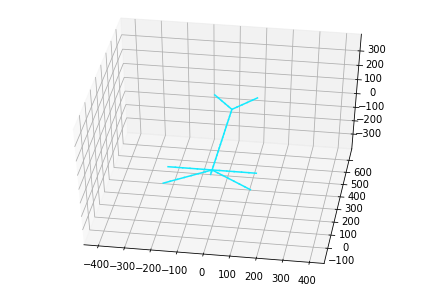

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

ps = h.PlotShape()
ps.plot(plt)
plt.show()